In [35]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from py_helper_functions import *

warnings.filterwarnings("ignore")

In [110]:
data_earnings = pd.read_csv("https://osf.io/4ay9x/download")

In [111]:
data_earnings.shape

(149316, 23)

In [112]:
data_earnings.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94'],
      dtype='object')

In [113]:
selected_job_codes = [800, 810, 820, 830, 840, 850, 860, 900, 910, 930, 940, 950]
financial_specialists_data = data_earnings[data_earnings['occ2012'].isin(selected_job_codes)]
#financial_specialists_data = data_earnings.loc[data_earnings["occ2012"] == 840, :]

In [114]:
financial_specialists_data['grade92'].unique()

array([43, 44, 42, 41, 39, 40, 45, 46, 38, 34, 37, 36, 35, 32, 31],
      dtype=int64)

In [115]:
# We want to focus on all employees with a graduate degree (more than 4-year college degree -> professional, master's and doctoral degree)
# Select people aged 24-65
# Exclude those who reported >=20 hours weekly time worked 
# And those with nonpositive reported earnings
financial_specialists_data = financial_specialists_data.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")

In [116]:
# There are 606 observations under "financial specalists" umbrella occupation title after some filters
financial_specialists_data.shape

(606, 23)

In [117]:
number_of_females = len(financial_specialists_data[financial_specialists_data["sex"] == 2])
number_of_males = len(financial_specialists_data[financial_specialists_data["sex"] == 1])

In [118]:
# There are 278 females and 328 males (total 606) working as a financial specialist
print(number_of_females)
print(number_of_males)

278
328


Create variables for the intended study/research

- female
- hourly wages
- log of hourly wages (dependent variable)

In [119]:
financial_specialists_data["female"] = (financial_specialists_data["sex"] == 2)
financial_specialists_data["w"] = financial_specialists_data["earnwke"] / financial_specialists_data["uhours"]
financial_specialists_data["lnw"] = np.log(financial_specialists_data["w"])

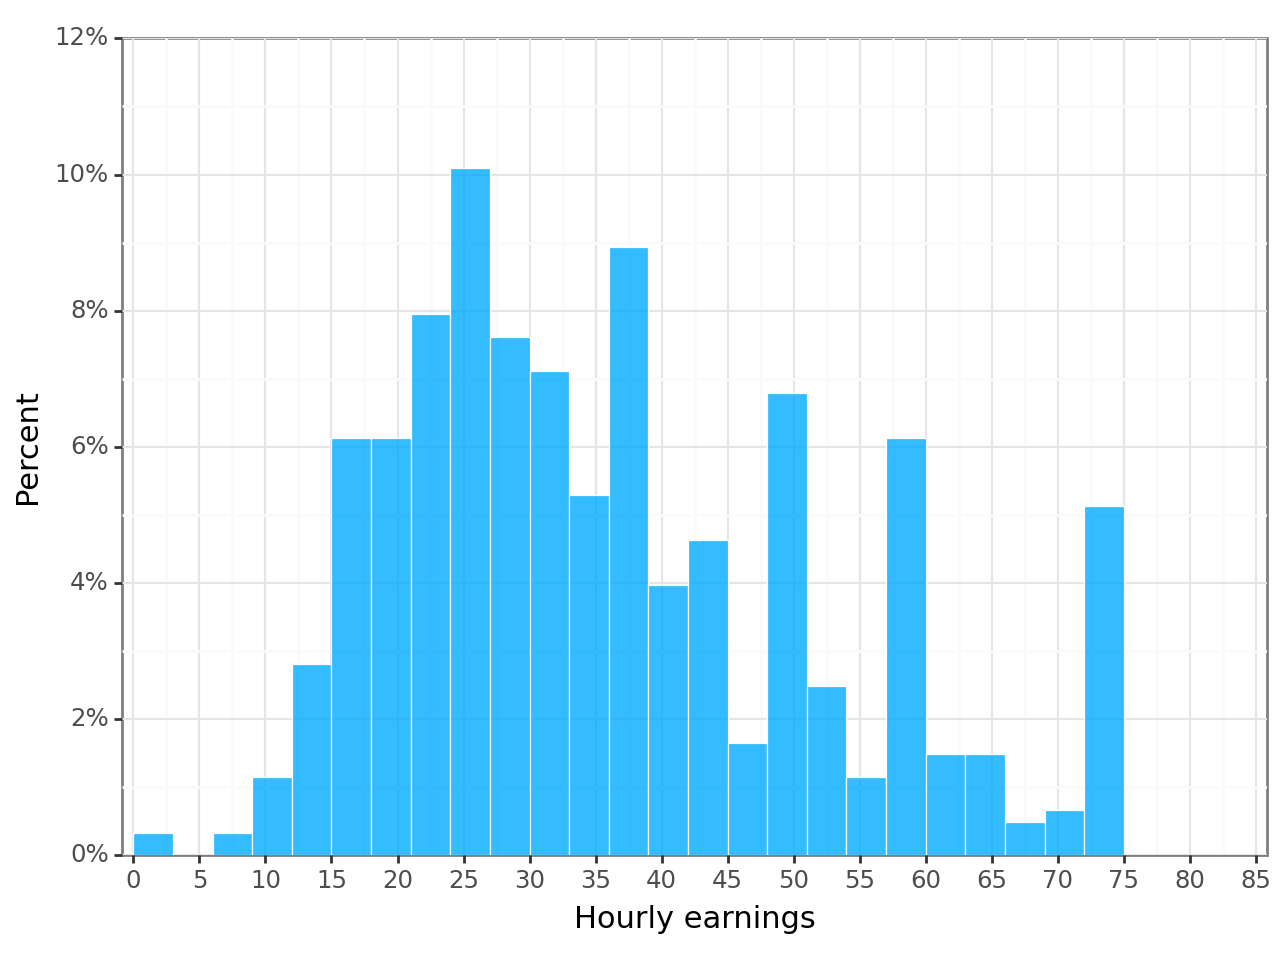

<Figure Size: (640 x 480)>

In [120]:
(
    ggplot(financial_specialists_data, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill= "#00abff",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 85), breaks=seq(0, 85, 5))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        breaks=seq(0, 0.12, 0.02),
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)

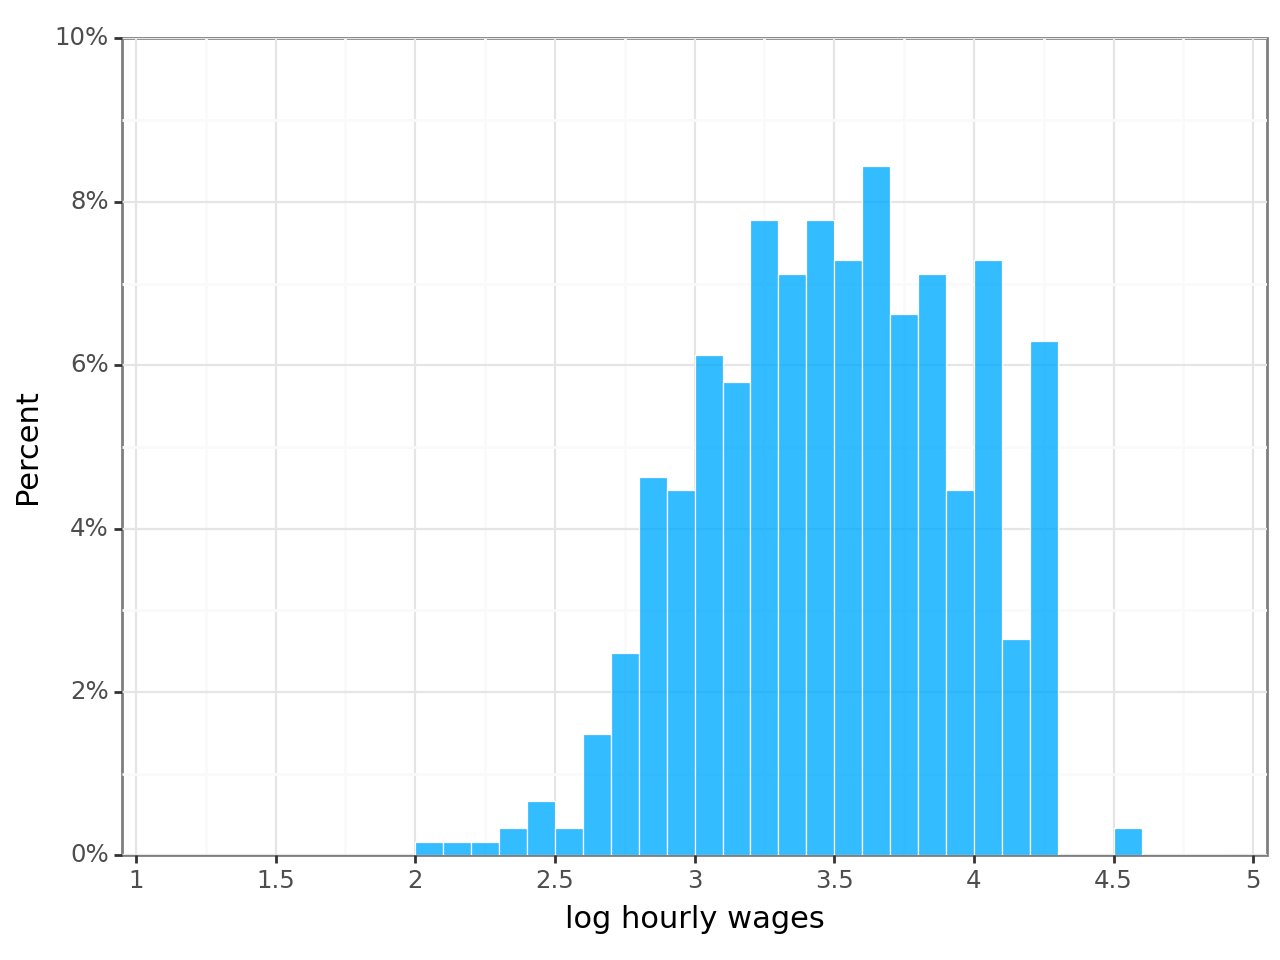

<Figure Size: (640 x 480)>

In [121]:
(
    ggplot(financial_specialists_data, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill="#00abff",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

In [122]:
financial_specialists_data.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,606.000000,606.000000,606.000000,606.000000
mean,1571.089802,42.924092,36.481955,3.483298
std,741.550855,7.226959,16.322489,0.554366
min,1.150000,20.000000,0.028750,-3.549118
25%,969.230000,40.000000,24.038250,3.179646
50%,1442.000000,40.000000,33.253167,3.504147
75%,2066.615000,45.000000,48.075000,3.872762
max,2884.610000,80.000000,96.153500,4.565946


In [123]:
financial_specialists_data["female"] = financial_specialists_data["female"].astype(int)  #from boolean to 0,1
financial_specialists_data["female"].value_counts()

female
0    328
1    278
Name: count, dtype: int64

### Earnings and female 
#### Linear regressions
**Log-level**:

$(\ln{w})^E = \alpha + \beta \times female$

In [124]:
reg1 = smf.ols(formula="lnw~female", data=financial_specialists_data).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     32.21
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           2.15e-08
Time:                        22:39:09   Log-Likelihood:                -486.14
No. Observations:                 606   AIC:                             976.3
Df Residuals:                     604   BIC:                             985.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5980      0.030    120.539      0.000       3.539       3.657
female        -0.2501      0.044     -5.676      0.000      -0.337      -0.164
==============================================================================
Omnibus:                      576.853   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51622.456
Skew:                          -3.857   Prob(JB):                         0.00
Kurtosis:                      47.553   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
reg2 = smf.ols(formula="lnw~female", data=financial_specialists_data).fit(cov_type="HC1") 
#heteroskedastic-consistent standard errors
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     30.34
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           5.38e-08
Time:                        22:39:29   Log-Likelihood:                -486.14
No. Observations:                 606   AIC:                             976.3
Df Residuals:                     604   BIC:                             985.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5980      0.024    148.797      0.000       3.551       3.645
female        -0.2501      0.045     -5.508      0.000      -0.339      -0.161
==============================================================================
Omnibus:                      576.853   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51622.456
Skew:                          -3.857   Prob(JB):                         0.00
Kurtosis:                      47.553   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Table 9.1 Wage and gender gap baseline regression

In [126]:
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

### Gender differences in earnings – log earnings, gender and education

In [127]:
financial_specialists_data["ed_MA"] = (financial_specialists_data["grade92"] == 44).astype(int) #master
financial_specialists_data["ed_Profess"] = (financial_specialists_data["grade92"] == 45).astype(int) #professional
financial_specialists_data["ed_Phd"] = (financial_specialists_data["grade92"] == 46).astype(int) #PhD

-> the category not represented is the **reference category**

-> coefficients on each $k-1$ dummy show average differences in $y$ compared to the reference category

In [128]:
reg3 = smf.ols(formula="lnw~female + ed_Profess + ed_Phd", data=financial_specialists_data).fit(cov_type="HC1")
reg4 = smf.ols(formula="lnw~female + ed_Profess + ed_MA", data=financial_specialists_data).fit(cov_type="HC1")

In [129]:
stargazer = Stargazer([reg2, reg3, reg4])
stargazer.covariate_order(["female", "ed_Profess", "ed_Phd", "ed_MA", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [ ]:
#csv_filename = 'output.csv'
#financial_specialists_data.to_csv(csv_filename, index=False)

In [26]:
#%%html
#<iframe src='output.csv' width='100%' height='350'></iframe>
